**Step 1**

Target:
1.  Get the set-up right
2.  Set Transforms
3.  Set Data Loader
4.  Set Basic Working Code
5.  Get the basic light model right. We will try and avoid changing this skeleton as much as possible.
6.  Results:
    1.  Parameters: 8474
    2.  Best Training Accuracy: 98.71 (15th epoch)
    3.  Best Test Accuracy: 98.79 (14th epoch)
7.  Analysis:
    1.  Model is under fitting. 
    2.  It is a good model can be pushed further.
  



# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))  
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments 
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Looking at data

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

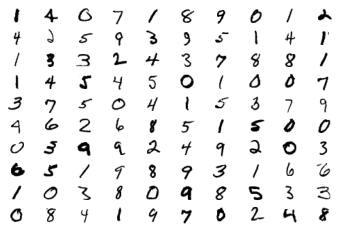

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [6]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) 


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),            
        ) 

        self.pool1 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )

        

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        ) 

        
        
        


        self.pool2 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        )

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),            
        ) 

        

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
        )
        self.pool3 = nn.Sequential(
            nn.MaxPool2d(2, 2)
        ) 

        self.convblock8= nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False)
        ) 

        
        self.gap= nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
            
        )

         # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)    #input-(28,28) Output-(28,28)   RF=3   input channels=1 output channels=10
        x = self.convblock2(x)    #input-(28,28) Output-(28,28)   RF=5   input channels=10 output channels=16
        x = self.convblock3(x)    #input-(28,28) Output-(28,28)   RF=5   input channels=16 output channels=10
        x = self.pool1(x)         #input-(28,28) Output-(14,14)   RF=6   input channels=10 output channels=10
        x = self.convblock4(x)    #input-(14,14) Output-(14,14)   RF=10   input channels=10 output channels=16
        x = self.convblock5(x)    #input-(14,14) Output-(14,14)   RF=14   input channels=16 output channels=16
        x = self.pool2(x)         #input-(14,14) Output-(7,7)     RF=16   input channels=16 output channels=16
        x = self.convblock6(x)    #input-(7,7) Output-(7,7)       RF=16   input channels=16 output channels=10
        x = self.convblock7(x)    #input-(7,7) Output-(7,7)       RF=24   input channels=10 output channels=16
        x = self.pool3(x)         #input-(7,7) Output-(3,3)       RF=28   input channels=16 output channels=16
        x = self.convblock8(x)    #input-(3,3) Output-(3,3)       RF=44   input channels=16 output channels=16


        x = self.gap(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           1,440
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             160
         MaxPool2d-6           [-1, 10, 14, 14]               0
            Conv2d-7           [-1, 16, 14, 14]           1,440
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,304
             ReLU-10           [-1, 16, 14, 14]               0
        MaxPool2d-11             [-1, 16, 7, 7]               0
           Conv2d-12             [-1, 10, 7, 7]             160
           Conv2d-13             [-1, 16, 7, 7]           1,440
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [8]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader,position=0, leave=True)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.3022429943084717 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3024, Accuracy: 980/10000 (9.80%)

EPOCH: 1


Loss=2.3022961616516113 Batch_id=468 Accuracy=9.87: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3018, Accuracy: 980/10000 (9.80%)

EPOCH: 2


Loss=0.4357568919658661 Batch_id=468 Accuracy=25.59: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4880, Accuracy: 8437/10000 (84.37%)

EPOCH: 3


Loss=0.1584564745426178 Batch_id=468 Accuracy=90.70: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1413, Accuracy: 9577/10000 (95.77%)

EPOCH: 4


Loss=0.11844342201948166 Batch_id=468 Accuracy=95.41: 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9703/10000 (97.03%)

EPOCH: 5


Loss=0.05641981586813927 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0887, Accuracy: 9713/10000 (97.13%)

EPOCH: 6


Loss=0.14661183953285217 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:12<00:00, 36.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9764/10000 (97.64%)

EPOCH: 7


Loss=0.06760300695896149 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:12<00:00, 36.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 9763/10000 (97.63%)

EPOCH: 8


Loss=0.03137077018618584 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9847/10000 (98.47%)

EPOCH: 9


Loss=0.032964084297418594 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:12<00:00, 36.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9831/10000 (98.31%)

EPOCH: 10


Loss=0.03610784560441971 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9851/10000 (98.51%)

EPOCH: 11


Loss=0.022543175145983696 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9872/10000 (98.72%)

EPOCH: 12


Loss=0.09256118535995483 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9830/10000 (98.30%)

EPOCH: 13


Loss=0.00396716920658946 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:12<00:00, 36.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9879/10000 (98.79%)

EPOCH: 14


Loss=0.03179479017853737 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]



Test set: Average loss: 0.0431, Accuracy: 9868/10000 (98.68%)



In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")